Here we build a Seasonal ARIMA model to predict the monthly sales of alcohol given previous sales.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") # ignore harmless warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Alcohol-Sales-Prediction

/content/drive/MyDrive/Alcohol-Sales-Prediction


In [4]:
df=pd.read_csv("data.csv")
df.head()

,Date,Sales
0,1/1/1992,3459
1,1/2/1992,3458
2,1/3/1992,4002
3,1/4/1992,4564
4,1/5/1992,4221


In [5]:
print(f"There are {df.shape[0]} rows in the dataset.")

There are 325 rows in the dataset.


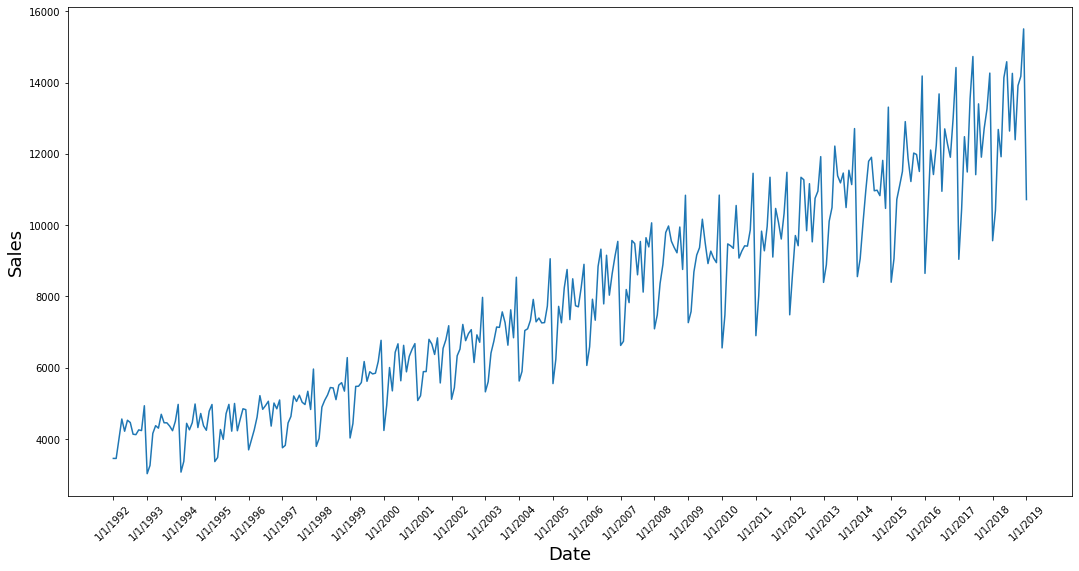

In [6]:
plt.figure(figsize = (18,9))
plt.plot(df['Date'], df['Sales'])
plt.xticks(np.arange(0,df.shape[0],12), rotation = 45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.show()

The variance of the alcohol sales increases with the mean, so we apply a Box–Cox transformation to the data.

In [7]:
df['Sales_boxcox'], param = boxcox(df['Sales']) # finds the lambda that maximizes the log-likelihood function before transforming the data
print('Optimal lambda:', param)

Optimal lambda: 0.2359961978310507


In [8]:
df.head()

,Date,Sales,Sales_boxcox
0,1/1/1992,3459,24.754356
1,1/2/1992,3458,24.752378
2,1/3/1992,4002,25.769375
3,1/4/1992,4564,26.714496
4,1/5/1992,4221,26.149042


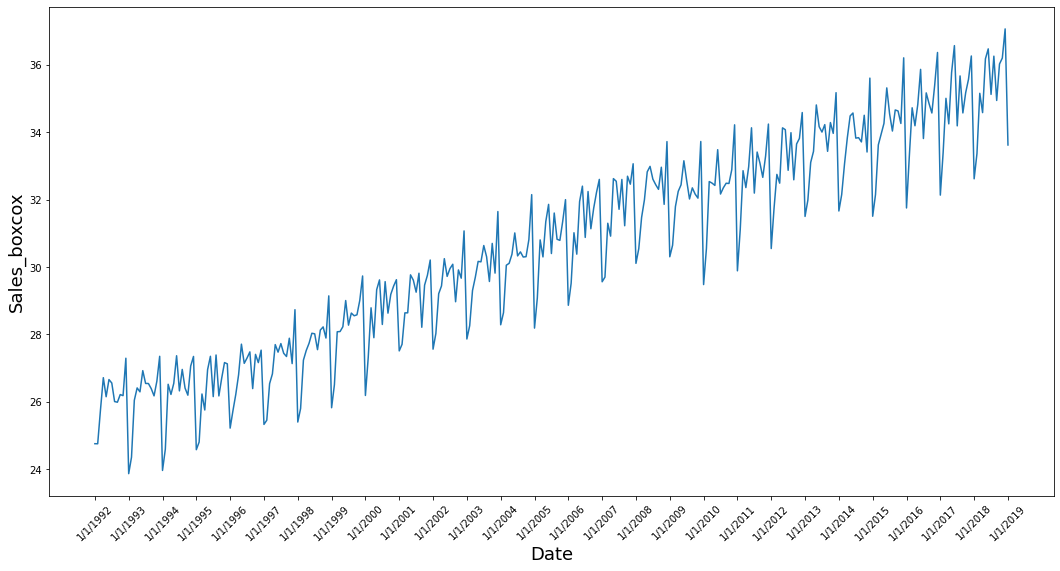

In [9]:
plt.figure(figsize = (18,9))
plt.plot(df['Date'], df['Sales_boxcox'])
plt.xticks(np.arange(0,df.shape[0],12), rotation = 45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales_boxcox', fontsize=18)
plt.show()

The transformed data has an approximately constant variance. We take a yearly seasonal difference and add the values to the dataframe.

In [10]:
df['difference_12'] = df['Sales_boxcox'] - df['Sales_boxcox'].shift(12)
df.head(15)

,Date,Sales,Sales_boxcox,difference_12
0,1/1/1992,3459,24.754356,NaN
1,1/2/1992,3458,24.752378,NaN
2,1/3/1992,4002,25.769375,NaN
3,1/4/1992,4564,26.714496,NaN
4,1/5/1992,4221,26.149042,NaN
5,1/6/1992,4529,26.658315,NaN
6,1/7/1992,4466,26.556348,NaN
7,1/8/1992,4137,26.005237,NaN
8,1/9/1992,4126,25.986240,NaN
9,1/10/1992,4259,26.213380,NaN


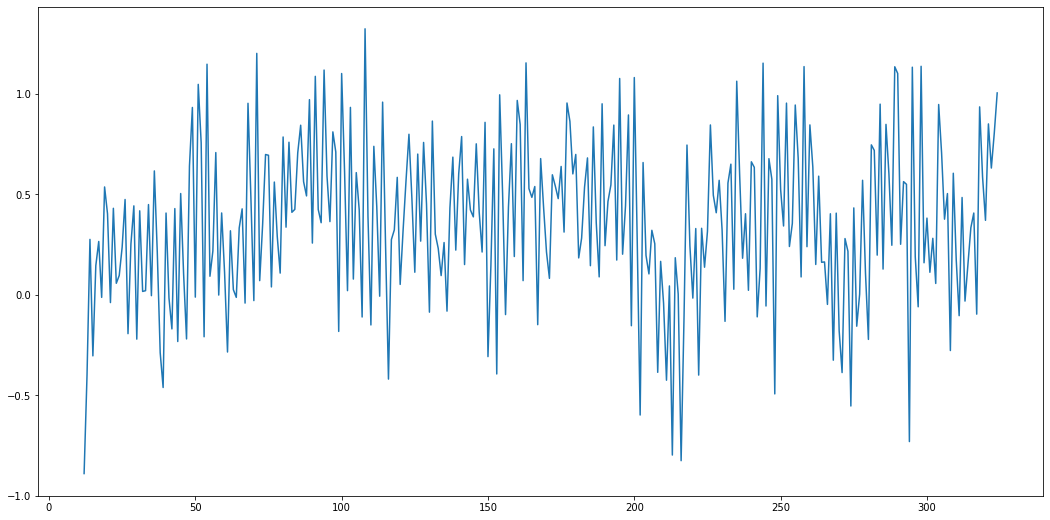

In [11]:
df['difference_12'].plot(figsize = (18,9))

We perform an Augmented Dickey-Fuller (ADF) test to test whether the time series difference_12 is stationary or not. The null hypothesis (p-value > 0.05) is that the series is non-stationary.

In [12]:
result = adfuller(df['difference_12'].iloc[12:])
print(f'ADF test statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Number of lags used: {result[2]}')
print(f'Number of observations used: {result[3]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'{key}, {value}')

ADF test statistic: -3.315441744209547
p-value: 0.014202181085686869
Number of lags used: 14
Number of observations used: 298
Critial Values:
1%, -3.4524859843440754
5%, -2.871288184343229
10%, -2.571964047565425


The p-value is smaller than 0.05 and the ADF statistic is similar to the critical values. This is evidence that difference_12 is stationary.

To get a starting point for the model parameters, we plot the autocorrelation function (ACF) and the partial autocorrelation function (PACF) on difference_12.

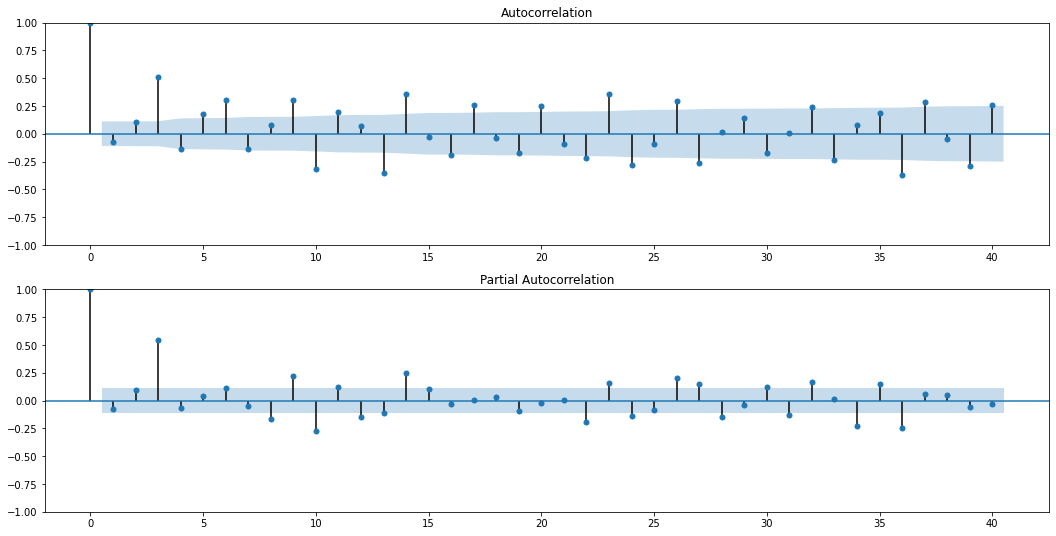

In [13]:
fig = plt.figure(figsize = (18,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['difference_12'].iloc[12:], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['difference_12'].iloc[12:], lags = 40, ax = ax2)

Both plots have significant lags but we will go ahead and treat the series as stationary. The ACF at lag 12 is insignificant, so we set the seasonal AR term (P) and the seasonal MA term (Q) to be 0. The ACF decays more slowly than the PACF, and the PACF has a significant positive spike at lag 3 despite having insignificant values at lags 1 and 2, which suggests an AR term (p) of 3. The difference term (d) is 0 and the seasonal difference term (D) is 1, which gives the model ARIMA(3,0,0)(0,1,0)[12].

We now find the best model using Auto ARIMA with ARIMA(3,0,0)(0,1,0)[12] as the initial model. Auto ARIMA performs a grid search over different parameter combinations and compares the relative quality of each model using AIC and also other checks.

In [34]:
SARIMA_model = auto_arima(df['Sales_boxcox'], start_p=3, start_q=0, max_p=3, max_q=3, m=12, start_P=0, start_Q=0, max_P=2,
                   max_Q=2, seasonal=True, d=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=219.747, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=332.660, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=333.623, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=332.577, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=508.513, Time=0.04 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=214.165, Time=1.95 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=195.776, Time=5.88 sec
 ARIMA(3,0,0)(2,1,1)[12] intercept   : AIC=133.296, Time=8.29 sec
 ARIMA(3,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(3,0,0)(2,1,2)[12] intercept   : AIC=113.518, Time=11.50 sec
 ARIMA(3,0,0)(1,1,2)[12] intercept   : AIC=144.547, Time=9.21 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=166.984, Time=9.14 sec
 ARIMA(3,0,1)(2,1,2)[12] intercept   : AIC=114.530, Time=12.79 sec
 ARIMA(2,0,1)(2,1,2)[12] intercept   : AIC=157.498, Time=9.84 sec
 ARIMA(3,0,0)(2,1,2)[12]           

Hence we choose ARIMA(3,0,0)(2,1,2)[12] as our final model. We try out this model by splitting the data into training and test sets.

In [37]:
num_train = 264 # size of training set
num_test = 61 # size of test set
training_set = df.iloc[:num_train, 2]
test_set = df.iloc[num_train:, 2]

We fit the model to the training data, then we forecast the sales for the next 61 months.

In [38]:
SARIMA_model.fit(training_set)

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 1, 2, 12),
      suppress_warnings=True)

In [39]:
SARIMA_forecast_boxcox = SARIMA_model.predict(n_periods=num_test)
SARIMA_forecast = inv_boxcox(SARIMA_forecast_boxcox, param)

In [40]:
print(f"Mean Squared Error between detransformed forecasts and test values is {mean_squared_error(df.iloc[num_train:, 1], SARIMA_forecast)}.")

Mean Squared Error between detransformed forecasts and test values is 188024.65889235065.


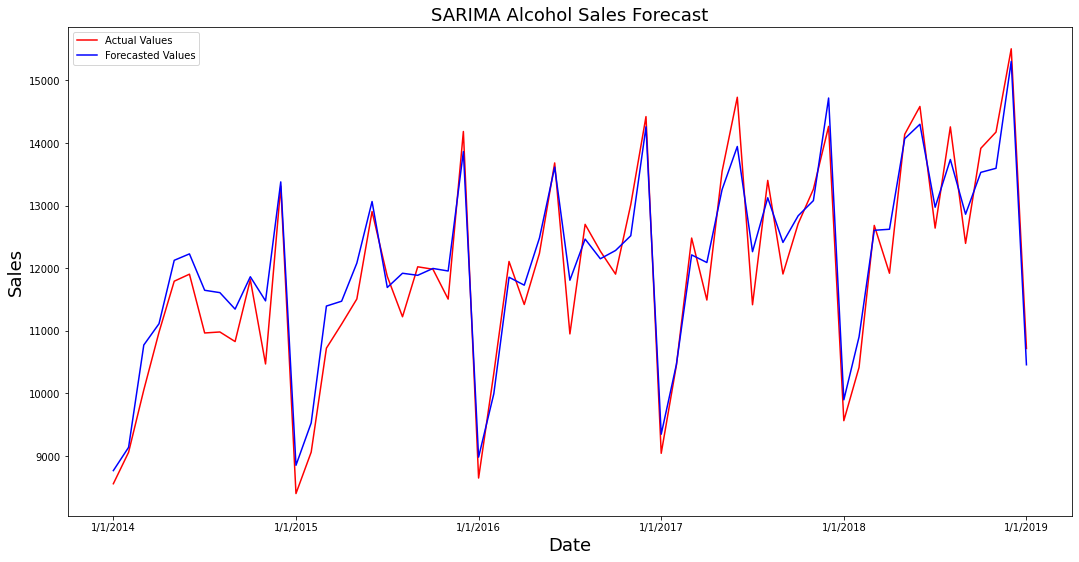

In [41]:
plt.figure(figsize = (18,9))
plt.plot(df.iloc[num_train:, 0], df.iloc[num_train:, 1], color='red', label='Actual Values')
plt.plot(df.iloc[num_train:, 0], SARIMA_forecast, color='blue', label='Forecasted Values')
plt.xticks(np.arange(0,num_test,12))
plt.title('SARIMA Alcohol Sales Forecast', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.legend()
plt.show()

This model yields an extraordinarily good performance considering that it doesn't use the test data. We now consider the case where for each test prediction, the model has access to all the previous data.

In [42]:
history = list(training_set.values)
SARIMA_predict_boxcox = []
for time in range(num_test):
    SARIMA_model.fit(history)
    output = SARIMA_model.predict(n_periods=1)[0]
    SARIMA_predict_boxcox.append(output)
    obs = test_set.iloc[time]
    history.append(obs)

In [43]:
SARIMA_predict = inv_boxcox(SARIMA_predict_boxcox, param)

In [44]:
print(f"Mean Squared Error between detransformed predictions and test values is {mean_squared_error(df.iloc[num_train:, 1], SARIMA_predict)}.")

Mean Squared Error between detransformed predictions and test values is 140413.5661701652.


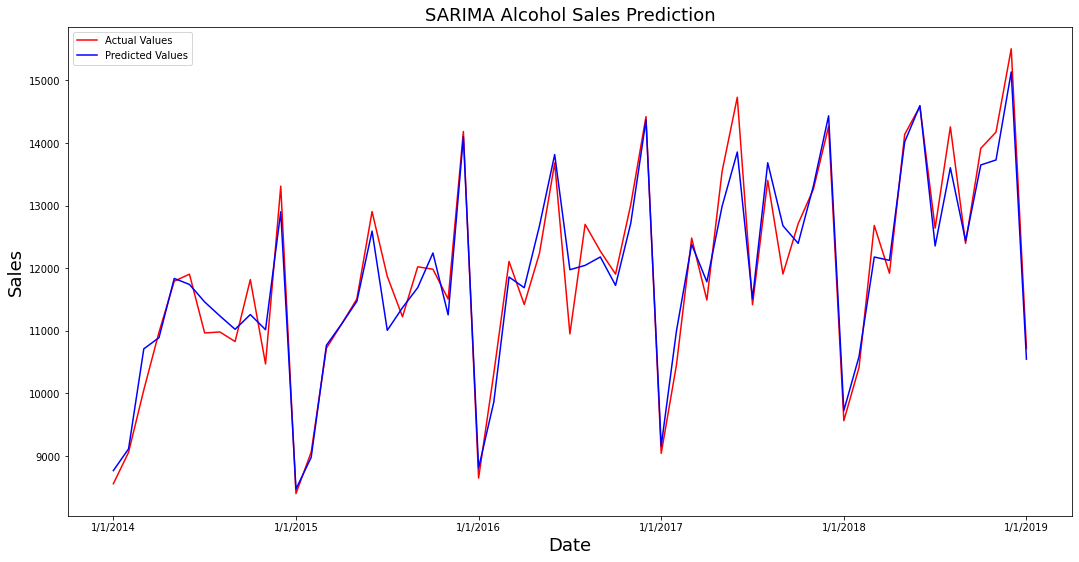

In [45]:
plt.figure(figsize = (18,9))
plt.plot(df.iloc[num_train:, 0], df.iloc[num_train:, 1], color='red', label='Actual Values')
plt.plot(df.iloc[num_train:, 0], SARIMA_predict, color='blue', label='Predicted Values')
plt.xticks(np.arange(0,num_test,12))
plt.title('SARIMA Alcohol Sales Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=18)
plt.legend()
plt.show()

The predicted sales are an even better fit to the test data compared to the forecasted sales as expected.